# HW10 

In [1]:
import transforms as tr
# import transforms_symbolic as st
import kinematics as kin
from dynamics import SerialArmDyn
# import kinematics_symbolic as kins
import time

import numpy as np
import sympy as sm
from sympy import UnevaluatedExpr as uneval
from IPython.display import display, Math
from sympy.physics.vector.printing import vlatex

np.set_printoptions(precision=4, suppress=True)

## Problem 1

### Part (a) Show that the inertia matrix M(q) for an n-link robot is always positive definite (look at the definition of a positive definite matrix on wikipedia if needed). The form of Kinetic energy for a n-link robot may help you here.

The definition of a positive definite matrix is as follows. Note this calculation will always give a scalar value. 

$$
x^T M(q) x > 0
$$

The definition for kinetic energy of a robot is as follows: 

$$
T = \frac{1}{2} \dot{q}^T M(q) \dot q \quad  > 0
$$

Note the kinetic energy of the robot is valid for all $\dot q > 0$. 

So, given that kinetic energy must be greater than zero if all $\dot q >0$, $M(q)$ must be positive definite. 

### Part (b) Consider a 3-link Cartesian manipulator (see picture with prismatic joint in the z, then y, then x direction of the global frame). Assume the links are rectangular instead of cylindrical and do the following:

#### (i) Compute the inertia tensor $I_i$ at the center of mass for each link $i = 1,2,3$ assuming that the links are uniform rectangular solids of length 1, width 1/4, height 1/4, and mass of 1.

In [2]:
a, b, c, x, y, z, rho = sm.symbols(r'a b c x y z \rho', real=True)
Ixx, Iyy, Izz, Ixy, Ixz, Iyz = sm.symbols(r'I_{xx} I_{yy} I_{zz} I_{xy} I_{xz} I_{yz}')
Ii = sm.MatrixSymbol(r'I_i', 3, 3)
# define variable dictionary
vd = {}

vd[Ii] = sm.Matrix([[Ixx, Ixy, Ixz],
                   [Ixy, Iyy, Iyz],
                   [Ixz, Ixy, Izz]])

display(Math(fr'{Ii}=' + vlatex(vd[Ii])))

<IPython.core.display.Math object>

In [3]:
bounds = (x,-a/2,a/2), (y,-b/2,b/2), (z,-c/2,c/2) # x, y, z bounds

# define integrals
vd[Ixx] = sm.Integral(rho*(y**2 + z**2), *bounds)
vd[Iyy] = sm.Integral(rho*(x**2 + z**2), *bounds)
vd[Izz] = sm.Integral(rho*(x**2 + y**2), *bounds)

vd[Ixy] = -sm.Integral(x*y*rho, *bounds)
vd[Ixz] = -sm.Integral(x*z*rho, *bounds)
vd[Iyz] = -sm.Integral(y*z*rho, *bounds)

display(Math(fr'{Ii}=' + vlatex( vd[Ii].subs(vd) )))

<IPython.core.display.Math object>

In [4]:
vd[Ii] = vd[Ii].subs(vd).doit()
display(Math(fr'{Ii}=' + vlatex( vd[Ii] )))

<IPython.core.display.Math object>

In [5]:
m = sm.symbols(r'm')

vd[Ii] = sm.expand(vd[Ii]).applyfunc(lambda expr: sm.collect(expr, rho*a*b*c)) # collect rho*a*b*c
vd[Ii] = vd[Ii].subs({rho*a*b*c: m}) # sub in values
vd[Ii] = sm.expand(vd[Ii]).applyfunc(lambda expr: sm.collect(expr, m)) # collect m values
print('sub in m = rho*volume = rho*a*b*c')
display(Math(fr'{Ii}=' + vlatex( vd[Ii] )))

sub in m = rho*volume = rho*a*b*c


<IPython.core.display.Math object>

Remember each link has a length of 1, width and height of 1/4:

In [11]:
vd[Ii] = vd[Ii].subs({a: sm.Rational(1,4),
                      b: sm.Rational(1,4),
                      c: 1,
                      m: 1}).doit()

print('I_i for each link:')
display(Math(fr'\Large {Ii}=' + vlatex( vd[Ii] ) +\
              r'=' + vlatex(vd[Ii].n(n=4))))

I_i for each link:


<IPython.core.display.Math object>

#### (ii) Compute the 3x3 inertia matrix $M(q)$ for this manipulator

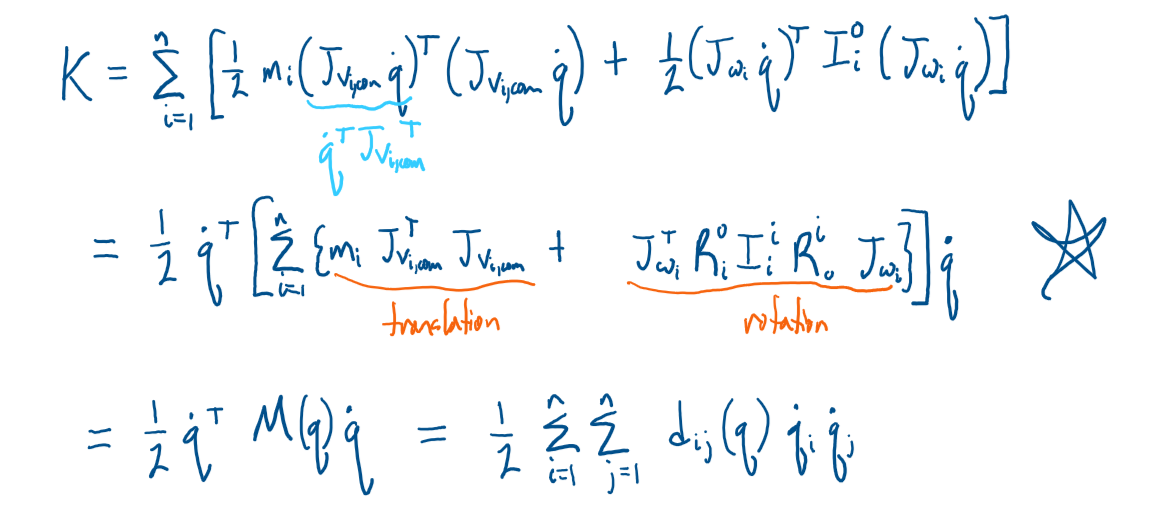

In [7]:
d = 1
dh = [[0, d, 0, -np.pi/2],
      [-np.pi/2, d, 0, -np.pi/2],
      [0, d, 0, 0]]
jt = ['p']*3
r = sm.Matrix(3, 1, [-0.5, 0, 0])
I = vd[Ii]
masses = [1] * 3

arm = kin.SerialArm(dh, joint_type=jt)

arm.jacob(q=sm.Matrix([0]*3))

arm = SerialArmDyn(dh,
                   jt=jt,
                   mass=[1]*3,
                   r_com=[r]*3,
                   link_inertia=[Ii]*3)

print('Because the J_com is the same for all links, we can just use the normal jacobian:')
arm.jacob_com()

Because the J_com is the same for all links, we can just use the normal jacobian:


[Matrix([
 [0, 0, 0],
 [0, 0, 0],
 [1, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0]]),
 Matrix([
 [0,                    0, 0],
 [0,                  1.0, 0],
 [1, 6.12323399573677e-17, 0],
 [0,                    0, 0],
 [0,                    0, 0],
 [0,                    0, 0]]),
 Matrix([
 [0,                    0,                   1.0],
 [0,                  1.0,  6.12323399573677e-17],
 [1, 6.12323399573677e-17, -6.12323399573677e-17],
 [0,                    0,                     0],
 [0,                    0,                     0],
 [0,                    0,                     0]])]

In [8]:
Jv_com = [arm.jacob_com()[i][:3, :] for i in range(len(masses))] # velocity jacobian for coms
# don't calculate the rotational component because it's all zero

M = sm.zeros(3, 3)
for i in range(len(masses)):
    M = M + masses[i] * Jv_com[i].T @ Jv_com[i]

print('Mass matrix:')
display(Math(r'M = ' + vlatex(M)))

Mass matrix:


<IPython.core.display.Math object>

#### (iii) Show that the Christoffel symbols $c_{ijk}$ are all zero for this robot. Interpret the meaning of this for the dynamic equations of motion.

$$
C(\mathbf{q}, \dot{\mathbf{q}}) \implies C_{kj} = \sum_{i=1}^n c_{ij,k}(\mathbf{q}) \dot{q}_i

$$

$$
= \sum_{i=1}^n \frac{1}{2} \left\{ \frac{\partial d_{ki}}{\partial q_i} + \frac{\partial d_{ki}}{\partial q_j} - \frac{\partial d_{ij}}{\partial q_k} \right\} \dot{q}^i
$$

Because all elements of $M$ are not functions of $q$, the partial with respect to $q$ will also be zero. So, 

$$
C(q,\dot q)= 
\begin{bmatrix}
0 & 0 & 0 \\
0 & 0 & 0 \\
0 & 0 & 0
\end{bmatrix}
$$

The fact that $c_{ijk}$ is zero means that there is no Coriolis effect on the robot, which makes sense because this robot is made of only prismatic joints, and thus has no rotational motion. 

#### (iv) Derive the equations of motion in matrix form:

$$
M(q)\ddot q + C(q,\dot q) \dot q + G(q) = (\tau \; \text{or} \; f)
$$

First, find the $G(q)$ matrix:

$$
\frac{\partial P}{\partial \mathbf{q}} = 
\begin{bmatrix}
\frac{\partial P}{\partial q_1} \\
\frac{\partial P}{\partial q_2} \\
\frac{\partial P}{\partial q_3} \\
\end{bmatrix}

\\
\quad
\\

P = m_1 g(q_1 + r_{z,1}) + 
m_2 g(q_1 + r_{z,2}) + 
m_3 g(q_1 + r_{z,3})
$$

$$
G(q) = 
\begin{bmatrix}
(m_1 + m_2 + m_3) g \\
0 \\
0
\end{bmatrix} = 
\begin{bmatrix}
3 g \\
0 \\
0
\end{bmatrix}
$$

In [9]:
G = sm.Matrix([3, 0, 0])

t = sm.symbols(r't')
q1, q2, q3 = sm.symbols(r'q1 q2 q3', cls=sm.Function)
q1, q2, q3 = q1(t), q2(t), q3(t)

q = sm.Matrix([q1, q2, q3])
qd = sm.diff(q, t)
qdd = sm.diff(q, t, 2)

display(Math(fr'q = ' + vlatex(q) +\
             fr', \quad \dot q = ' + vlatex(qd) +\
             fr', \quad \ddot q = ' + vlatex(qdd)))

<IPython.core.display.Math object>

Equations in this form:

$$
M(q)\ddot q + C(q,\dot q) \dot q + G(q) = (\tau \; \text{or} \; f)
$$

In [10]:
display(Math(r'\tau = M(q)\ddot q + C(q, \dot q)\dot q + G(q) = ' + vlatex(M@qdd + G)))

<IPython.core.display.Math object>